In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt
import torchvision.transforms as T
import logging

In [2]:
class CocoColorizationDataset(Dataset):
    """
        L: [1, H, W]   ([0,1])
        ab: [2, H, W]  ([-1,1])
    """
    def __init__(self, root_dir="data/coco/train2017", transform_size=128, limit=5000):
        super().__init__()
        self.root_dir = root_dir
        self.size = transform_size
        valid_extensions = {".jpg", ".jpeg", ".png"}
        self.files = [fname for fname in sorted(os.listdir(root_dir))
                      if os.path.splitext(fname)[1].lower() in valid_extensions]
        self.files = self.files[:limit]
        self.transform = T.Compose([
            T.RandomResizedCrop(self.size, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
            T.RandomHorizontalFlip()
        ])
        print(f"Found {len(self.files)} valid images in {self.root_dir}")

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.root_dir, fname)
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        img_np = np.array(img).astype(np.float32) / 255.0
        lab = rgb2lab(img_np)
        L = lab[:, :, 0]       # [0, 100]
        ab = lab[:, :, 1:3]    # [-128, 127]
        L = L / 100.0          # [0,1]
        ab = ab / 128.0        # [-1,1]
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2,0,1)
        return L, ab

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class EnhancedDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.proj = None
        if in_channels != out_channels:
            self.proj = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.proj is not None:
            identity = self.proj(identity)
        out = out + identity
        out = self.relu(out)
        return out


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class LightDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, kernel_size=3, padding=1),
            DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1)
        )
    def forward(self, x):
        return self.conv(x)
    

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, conv_block=DoubleConv):
        super().__init__()
        self.double_conv = conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x_conv = self.double_conv(x)
        x_pool = self.pool(x_conv)
        return x_conv, x_pool

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, conv_block=DoubleConv):
        super().__init__()
        self.up_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = conv_block(out_channels * 2, out_channels)
    def forward(self, x, skip):
        x = self.up_transpose(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


class UNetColorNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, conv_block=DoubleConv, se_reduction: int = 16):
        super().__init__()
        self.down1 = Down(in_channels, 48, conv_block=conv_block)
        self.down2 = Down(48, 96, conv_block=conv_block)
        self.down3 = Down(96, 192, conv_block=conv_block)
        self.down4 = Down(192, 384, conv_block=conv_block)
        self.down5 = Down(384, 384, conv_block=conv_block)
        self.down6 = Down(384, 384, conv_block=conv_block)
        self.down7 = Down(384, 384, conv_block=conv_block)
        self.bottleneck = conv_block(384, 512)
        
        C_btm = 512
        # SE 分支：全局平均 -> 降维 -> 升维 -> sigmoid
        self.se_reduce = nn.Conv2d(C_btm, C_btm//se_reduction, kernel_size=1)
        self.se_expand = nn.Conv2d(C_btm//se_reduction, C_btm, kernel_size=1)

        self.up1 = Up(512, 384, conv_block=conv_block)
        self.up2 = Up(384, 384, conv_block=conv_block)
        self.up3 = Up(384, 384, conv_block=conv_block)
        self.up4 = Up(384, 384, conv_block=conv_block)
        self.up5 = Up(384, 192, conv_block=conv_block)
        self.up6 = Up(192, 96, conv_block=conv_block)
        self.up7 = Up(96, 48, conv_block=conv_block)
        self.final_conv = nn.Conv2d(48, out_channels, kernel_size=1)
        self.out_activation = nn.Tanh()
    def forward(self, x):
        d1, d1p = self.down1(x)      # [B,48,H,W]
        d2, d2p = self.down2(d1p)     # [B,96,H/2,W/2]
        d3, d3p = self.down3(d2p)     # [B,192,H/4,W/4]
        d4, d4p = self.down4(d3p)     # [B,384,H/8,W/8]
        d5, d5p = self.down5(d4p)     # [B,384,H/16,W/16]
        d6, d6p = self.down6(d5p)     # [B,384,H/32,W/32]
        d7, d7p = self.down7(d6p)     # [B,384,H/64,W/64]
        btm = self.bottleneck(d7p)    # [B,512,H/64,W/64]

        # Squeeze
        se = F.adaptive_avg_pool2d(btm, (1,1)) # [B,512,1,1]
        se = F.relu(self.se_reduce(se))
        se = torch.sigmoid(self.se_expand(se))
        # Excite
        btm = btm * se                         # [B,512,H/64,W/64]
        
        u1 = self.up1(btm, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        out = self.final_conv(u7)
        out = self.out_activation(out)
        return out 

In [4]:
import torch.nn.functional as F

class EditNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=1, conv_block=DoubleConv, se_reduction: int = 16):
        """
          down1: 5 -> 8
          down2: 8 -> 16
          down3: 16 -> 32
          down4: 32 -> 32
          down5: 32 -> 32
          down6: 32 -> 32
          down7: 32 -> 32
          bottleneck: 32 -> 64
          up1: 64 -> 32 (skip from down7)
          up2: 32 -> 32 (skip from down6)
          up3: 32 -> 32 (skip from down5)
          up4: 32 -> 32 (skip from down4)
          up5: 32 -> 32 (skip from down3)
          up6: 32 -> 16 (skip from down2)
          up7: 16 -> 8  (skip from down1)
          final: 8 -> 1 (heatmap)
        """
        super().__init__()
        self.down1 = Down(in_channels, 8, conv_block=conv_block)
        self.down2 = Down(8, 16, conv_block=conv_block)
        self.down3 = Down(16, 32, conv_block=conv_block)
        self.down4 = Down(32, 32, conv_block=conv_block)
        self.down5 = Down(32, 32, conv_block=conv_block)
        self.down6 = Down(32, 32, conv_block=conv_block)
        self.down7 = Down(32, 32, conv_block=conv_block)
        self.bottleneck = conv_block(32, 64)

        C_btm = 64
        self.se_reduce = nn.Conv2d(C_btm, C_btm//se_reduction, kernel_size=1)
        self.se_expand = nn.Conv2d(C_btm//se_reduction, C_btm, kernel_size=1)
        
        self.up1 = Up(64, 32, conv_block=conv_block)
        self.up2 = Up(32, 32, conv_block=conv_block)
        self.up3 = Up(32, 32, conv_block=conv_block)
        self.up4 = Up(32, 32, conv_block=conv_block)
        self.up5 = Up(32, 32, conv_block=conv_block)
        self.up6 = Up(32, 16, conv_block=conv_block)
        self.up7 = Up(16, 8, conv_block=conv_block)
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(self, gt_ab, pred_ab, gray):
        # gt_ab (2) + pred_ab (2) + gray (1) --> [B, 5, H, W]
        x = torch.cat([gt_ab, pred_ab, gray], dim=1)
        d1, d1p = self.down1(x)    # [B,8,H,W]
        d2, d2p = self.down2(d1p)   # [B,16,H/2,W/2]
        d3, d3p = self.down3(d2p)   # [B,32,H/4,W/4]
        d4, d4p = self.down4(d3p)   # [B,32,H/8,W/8]
        d5, d5p = self.down5(d4p)   # [B,32,H/16,W/16]
        d6, d6p = self.down6(d5p)   # [B,32,H/32,W/32]
        d7, d7p = self.down7(d6p)   # [B,32,H/64,W/64]
        btm = self.bottleneck(d7p)  # [B,64,H/64,W/64]

        se = F.adaptive_avg_pool2d(btm, (1,1))
        se = F.relu(self.se_reduce(se))
        se = torch.sigmoid(self.se_expand(se))
        btm = btm * se
        
        u1 = self.up1(btm, d7)      # [B,32,H/32,W/32]
        u2 = self.up2(u1, d6)       # [B,32,H/16,W/16]
        u3 = self.up3(u2, d5)       # [B,32,H/8,W/8]
        u4 = self.up4(u3, d4)       # [B,32,H/4,W/4]
        u5 = self.up5(u4, d3)       # [B,32,H/2,W/2]
        u6 = self.up6(u5, d2)       # [B,16,H,W]
        u7 = self.up7(u6, d1)       # [B,8,H,W]

        out = self.final_conv(u7)       # [B,1,H,W]  logits
        return out

In [5]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
# import lpips
from skimage.metrics import structural_similarity as ssim

def compute_gt_heatmap(pred_ab, gt_ab, threshold=0.3):
    """
    The binary heat map <-- MAE between ColorNet prediction and true ab
    1 if error > threshold, otherwise 0
    """
    error = torch.mean(torch.abs(pred_ab - gt_ab), dim=1, keepdim=True)  # [B,1,H,W]
    gt_heatmap = (error > threshold).float()
    return gt_heatmap

def initial_clickmap(x_L, x_ab, num_clicks=50):
    """
    random choose num_clicks pixel
    set click position as 1 on clickmask
    in ab channel, ab value of GT at postion of clickmask, other place 0 
    input:
      x_L: [B, 1, H, W] L channel
      x_ab: [B, 2, H, W] ab channel of GT
    output:
      clickmap: [B, 3, H, W] clickmask + ab
    """
    B, _, H, W = x_L.shape
    clickmap = torch.zeros(B, 3, H, W, device=x_L.device)
    for b in range(B):
        num_pixels = H * W
        indices = np.random.choice(num_pixels, num_clicks, replace=False)
        ys = indices // W
        xs = indices % W
        for y, x in zip(ys, xs):
            clickmap[b, 0, y, x] = 1.0
            clickmap[b, 1:, y, x] = x_ab[b, :, y, x]
    return clickmap

def update_clickmap(current_click, pred_click, x_ab):
    """
    use argmax on heatmap to get click position and update clickmap

    With EditNet update cumulative clickmap
      current_click: [B,3,H,W] current cumulative clickmap (1 channel clickmask, 2 ab channel)
      pred_click:  [B,1,H,W] EditNet predicted [0,1]
      x_ab:        [B,2,H,W] GT ab 

    Find the pixel position with the highest heatmap value in the unclicked location
    """
    new_click = current_click.clone()
    B, _, H, W = pred_click.shape
    for b in range(B):
        unclicked = (new_click[b, 0, :, :] == 0)
        masked_pred = pred_click[b, 0, :, :].clone()
        masked_pred[~unclicked] = -float('inf')
        flat_idx = torch.argmax(masked_pred)
        y = flat_idx // W
        x = flat_idx % W
        new_click[b, 0, y, x] = 1.0
        new_click[b, 1:3, y, x] = x_ab[b, :, y, x]
    return new_click


BIG_NEG = -1e4
@torch.no_grad()
def update_clickmap_gumbel_train(clickmap: torch.Tensor,
                                 pred_logits: torch.Tensor,
                                 gt_ab: torch.Tensor,
                                 tau: float = 1.0) -> torch.Tensor:
    """
    Vectorized Gumbel-Softmax click update  (no Python for-loop)
    ----------------------------------------------------------------
    clickmap : [B,3,H,W]  (ch-0: click flag, ch-1/2: sum ab values)
    pred_logits : [B,1,H,W]  (EditNet logits per pixel)
    gt_ab : [B,2,H,W]        (ground-truth ab channels)
    tau : temperature
    Returns a **new** clickmap tensor (out-of-place)
    """
    B, _, H, W = clickmap.shape

    # 1) 未点击掩码
    unclicked = (clickmap[:, 0] == 0)               # [B,H,W], bool

    # 2) 屏蔽已点击像素，避免 -inf 溢出 (AMP safe)
    logits = pred_logits.squeeze(1)                 # [B,H,W]
    masked = logits * unclicked + (~unclicked) * BIG_NEG   # [B,H,W]

    # 3) 展平后一次 Gumbel-Softmax 采样 → one-hot
    one_hot_flat = F.gumbel_softmax(
        masked.view(B, -1), tau=tau, hard=True, dim=-1)    # [B,H*W]
    one_hot = one_hot_flat.view(B, H, W)                   # [B,H,W]

    # 4) 更新 clickmap 各通道
    ch0 = torch.maximum(clickmap[:, 0], one_hot)           # flag
    ch1 = clickmap[:, 1] + one_hot * gt_ab[:, 0]           # a*
    ch2 = clickmap[:, 2] + one_hot * gt_ab[:, 1]           # b*

    return torch.stack([ch0, ch1, ch2], dim=1)             # [B,3,H,W]

def compute_psnr(pred, target):
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    mse = torch.mean((pred - target)**2)
    if torch.isnan(mse) or torch.isinf(mse): # 检查 mse
        print(f"DEBUG: compute_psnr found NaN/Inf in MSE: {mse.item()}")
        print(f"       pred min/max/mean: {pred.min().item():.4f}/{pred.max().item():.4f}/{pred.mean().item():.4f}")
        print(f"       target min/max/mean: {target.min().item():.4f}/{target.max().item():.4f}/{target.mean().item():.4f}")
        return 0.0 # 或者返回 NaN 以便上层知道出错了
    if mse == 0:
        return 100.0
    psnr = 10 * torch.log10(1.0 / mse)
    return psnr.item()

def lab_to_rgb_tensor(x_L: torch.Tensor, x_ab: torch.Tensor) -> torch.Tensor:
    """
    x_L:  [1, H, W] 或 [H, W]  的 L 通道，范围 [0,1]
    x_ab: [1, 2, H, W] 或 [2, H, W] 的 ab 通道，大约是 [-1,1]
    返回： [3, H, W] 的 RGB 张量，范围 [0,1]
    """
    # 去掉 batch 维
    L_np = x_L.squeeze(0).cpu().numpy()      # [H, W]
    ab_np = x_ab.squeeze(0).cpu().numpy()    # [2, H, W]

    # 恢复 Lab 原始范围
    L = L_np * 100                           # [H, W]
    ab = ab_np * 127                         # [2, H, W]

    # stack 成 [H, W, 3]
    lab = np.stack([L, ab[0], ab[1]], axis=-1)

    # 转换到 RGB
    rgb = lab2rgb(lab)                       # [H, W, 3], float64 in [0,1]
    rgb = np.clip(rgb, 0.0, 1.0)
    # 回成 torch.Tensor [3, H, W]
    return torch.from_numpy(rgb).permute(2, 0, 1).float()

def compute_ssim(pr_np, gt_np):
    """
    pr_np, gt_np: numpy arrays, shape (H, W, C)
    返回 SSIM 标量
    """
    h, w = pr_np.shape[:2]
    # 最大 window，不超过最小边长，且保持为奇数
    max_win = 7
    min_hw = min(h, w)
    win = max_win if min_hw >= max_win else (min_hw // 2) * 2 + 1
    # 新版 skimage API：用 channel_axis 指明通道
    return ssim(
        pr_np, gt_np,
        win_size=win,
        data_range=gt_np.max() - gt_np.min(),
        channel_axis=-1
    )

def freeze_bn(model: nn.Module):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()                      # 固定 running_mean / var
            m.weight.requires_grad_(False)
            m.bias.requires_grad_(False)

class CompositeLoss(nn.Module):
    def __init__(self, pixel_loss_weight=1.0, lpips_weight=0.1):
        super().__init__()
        self.pixel_loss = nn.L1Loss()
        self.lpips_loss = lpips.LPIPS(net='alex')
        self.pixel_loss_weight = pixel_loss_weight
        self.lpips_weight = lpips_weight

    def forward(self, pred, target):
        loss_pixel = self.pixel_loss(pred, target)
        if pred.shape[1] == 2:
            pred_3ch = torch.cat([pred, torch.zeros_like(pred[:, :1])], dim=1)
            target_3ch = torch.cat([target, torch.zeros_like(target[:, :1])], dim=1)
        else:
            pred_3ch = pred
            target_3ch = target
        loss_lpips = self.lpips_loss(pred_3ch, target_3ch).mean()
        total_loss = self.pixel_loss_weight * loss_pixel + self.lpips_weight * loss_lpips
        return total_loss

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.color import lab2rgb
import torchvision.transforms as T

def train_color_net_epoch(
        colornet, dataloader, optimizer, scheduler, device, composite_loss,
        total_clicks=20, clip_grad=1.0):
    """
    预训练 ColorNet：从 1 个随机点击开始，逐步累积随机点击，
    每次前向都计算一次 loss，最后在一个 batch 上将所有 loss 累加后反向。
    Args:
        colornet      : UNetColorNet 模型
        dataloader    : 训练集 DataLoader
        optimizer     : 优化器
        device        : 设备 ("cuda" 或 "cpu")
        composite_loss: CompositeLoss 实例
        total_clicks  : 最终要累积的点击总数（默认为 20）
        clip_grad     : 梯度裁剪阈值
    """
    colornet.train()
    scaler = GradScaler()
    total_epoch_loss = 0.0

    for x_L, x_ab in dataloader:
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        B, _, H, W = x_L.shape

        # 1) 先随机生成一个点击
        cumulative_click = initial_clickmap(x_L, x_ab, num_clicks=1).to(device)
        loss_accum = 0.0

        # 2) 第一次前向和 loss
        with autocast(device_type=device.type):
            inp = torch.cat([x_L, cumulative_click], dim=1)
            pred_ab = colornet(inp)
            loss_accum = composite_loss(pred_ab, x_ab)

        # 3) 依次再累积剩余的 (total_clicks-1) 个随机点击
        for _ in range(total_clicks - 1):
            # 3.1 新随机点击
            new_click = initial_clickmap(x_L, x_ab, num_clicks=1).to(device)
            # 3.2 只在之前未点击的位置上叠加
            mask = (cumulative_click[:, 0:1] == 0.0)
            added_mask = new_click[:, 0:1] * mask
            cumulative_click[:, 0:1] += added_mask
            cumulative_click[:, 1:3] += new_click[:, 1:3] * added_mask

            # 3.3 再次前向和 loss
            with autocast(device_type=device.type):
                inp = torch.cat([x_L, cumulative_click], dim=1)
                pred_ab = colornet(inp)
                loss_accum += composite_loss(pred_ab, x_ab)

        # 4) 一个 batch 上所有 step 的 loss 累加后反向
        optimizer.zero_grad()
        scaler.scale(loss_accum).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(colornet.parameters(), max_norm=clip_grad)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_epoch_loss += loss_accum.item()

    return total_epoch_loss / len(dataloader)


def train_edit_net_epoch(
    colornet,
    editnet,
    dataloader,
    optimizer,
    device,           # ← 先接 device
    scheduler,        # ← 再接 scheduler
    criterion_color,
    num_iterations: int = 9,
    lambda_entropy: float = 0.01,
    tau: float = 1.0,
    scaler: GradScaler | None = None,
):
    """
    Updated training for EditNet: removes explicit heatmap loss, retains entropy regularization,
    uses Gumbel-Softmax for click updates with explicit temperature tau and AMP.
    """
    editnet.train()
    colornet.eval()

    for p in colornet.parameters():
        p.requires_grad_(False)

    total_combined_loss = 0.0
    total_color_loss_log = 0.0
    total_entropy_log = 0.0

    for batch_idx, (x_L, x_ab) in enumerate(dataloader):
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        B, _, H, W = x_L.shape

        cumulative_click = torch.zeros(B, 3, H, W, device=device)
        pred_ab_current = torch.zeros(B, 2, H, W, device=device)

        color_loss_accum = 0.0
        entropy_accum = 0.0

        # 初始点击步骤
        with autocast(device_type=device.type):
            pred_logits = editnet(x_ab, pred_ab_current, x_L)
            Q = F.softmax(pred_logits.view(B, -1), dim=1)
            logQ = torch.log(Q + 1e-8)
            entropy_accum += -(Q * logQ).sum(dim=1).mean()

        cumulative_click = update_clickmap_gumbel_train(
            cumulative_click, pred_logits, x_ab, tau=tau
        )

        with autocast(device_type=device.type):
            colornet_input = torch.cat([x_L, cumulative_click], dim=1)
            pred_ab_current = colornet(colornet_input)
            color_loss_accum += criterion_color(pred_ab_current, x_ab)

        for _ in range(num_iterations):
            with autocast(device_type=device.type):
                pred_logits = editnet(x_ab, pred_ab_current.detach(), x_L)
                Q = F.softmax(pred_logits.view(B, -1), dim=1)
                logQ = torch.log(Q + 1e-8)
                entropy_accum += -(Q * logQ).sum(dim=1).mean()

            cumulative_click = update_clickmap_gumbel_train(
                cumulative_click, pred_logits, x_ab, tau=tau
            )

            with autocast(device_type=device.type):
                colornet_input = torch.cat([x_L, cumulative_click], dim=1)
                pred_ab_current = colornet(colornet_input)
                color_loss_accum += criterion_color(pred_ab_current, x_ab)

        final_color_loss = color_loss_accum / (num_iterations + 1)
        final_entropy = entropy_accum / (num_iterations + 1)
        combined_loss = final_color_loss - lambda_entropy * final_entropy

        optimizer.zero_grad()
        scaler.scale(combined_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(editnet.parameters(), max_norm=1.0)
        try:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        except AssertionError:
            # Fallback to standard step
            optimizer.step()

        total_combined_loss += combined_loss.item()
        total_color_loss_log += final_color_loss.item()
        total_entropy_log += final_entropy.item()

    avg_combined_loss = total_combined_loss / len(dataloader)
    avg_color_loss = total_color_loss_log / len(dataloader)
    avg_entropy = total_entropy_log / len(dataloader)
    print(f"  Avg Combined Loss: {avg_combined_loss:.4f}, Avg Color Loss: {avg_color_loss:.4f}, Avg Entropy: {avg_entropy:.4f}")
    return avg_combined_loss

# --- Phase 3a: Ping Pong training —— freeze train ColorNet ---
def train_color_net_pingpong_epoch(colornet, editnet, dataloader, optimizer, device, composite_loss, num_iterations=4, tau=1.0, initial_clicks=1, clip_grad=1.0):
    colornet.train()
    editnet.eval()

    # 设置 requires_grad
    for param in colornet.parameters():
        param.requires_grad = True
    for param in editnet.parameters():
        param.requires_grad = False

    scaler = GradScaler()
    total_loss = 0.0

    for x_L, x_ab in dataloader:
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        B, _, H, W = x_L.shape

        cumulative_click = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)

        loss_accum = 0.0
        inp = torch.cat([x_L, cumulative_click], dim=1)
        with autocast(device_type=device.type):
            pred_ab = colornet(inp)
            current_loss = composite_loss(pred_ab, x_ab)
        loss_accum = current_loss

        for i in range(num_iterations):
            with torch.no_grad():
                with autocast(device_type=device.type):
                    pred_click_heatmap = editnet(x_ab, pred_ab.detach(), x_L)

            cumulative_click = update_clickmap_gumbel_train(cumulative_click, pred_click_heatmap, x_ab, tau=tau)

            inp = torch.cat([x_L, cumulative_click], dim=1)
            with autocast(device_type=device.type):
                pred_ab = colornet(inp)
                current_loss = composite_loss(pred_ab, x_ab)

            loss_accum += current_loss

        optimizer.zero_grad()
        scaler.scale(loss_accum).backward()
        scaler.unscale_(optimizer) # 先 unscale 梯度
        torch.nn.utils.clip_grad_norm_(colornet.parameters(), max_norm=clip_grad)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss_accum.item()
    return total_loss / len(dataloader)

# --- Phase 3b: Ping Pong training —— freeze train EditNet ---
def train_edit_net_pingpong_epoch(
    colornet,
    editnet,
    dataloader,
    optimizer,
    device,           # ← 先接 device
    scheduler,        # ← 再接 scheduler
    criterion_color,
    num_iterations: int = 9,
    lambda_entropy: float = 0.01,
    tau: float = 1.0,
    scaler: GradScaler | None = None,
):
    assert scaler is not None, "请传入全局共享的 GradScaler"
    editnet.train()
    colornet.eval()

    for p in editnet.parameters():
        p.requires_grad = True
    for p in colornet.parameters():
        p.requires_grad = False

    total_combined_loss = 0.0
    total_color_loss_log = 0.0
    total_entropy_log = 0.0

    for batch_idx, (x_L, x_ab) in enumerate(dataloader):
        x_L, x_ab = x_L.to(device), x_ab.to(device)
        B, _, H, W = x_L.shape

        cumulative_click = torch.zeros(B, 3, H, W, device=device)
        pred_ab_current = torch.zeros(B, 2, H, W, device=device)

        color_loss_accum = 0.0
        entropy_accum = 0.0

        # 初始点击步骤
        with autocast(device_type=device.type):
            pred_logits = editnet(x_ab, pred_ab_current, x_L)
            Q = F.softmax(pred_logits.detach().view(B, -1), dim=1)
            logQ = torch.log(Q + 1e-8)
            entropy_accum += -(Q * logQ).sum(dim=1).mean()

        cumulative_click = update_clickmap_gumbel_train(
            cumulative_click, pred_logits, x_ab, tau=tau
        )

        with autocast(device_type=device.type):
            colornet_input = torch.cat([x_L, cumulative_click], dim=1)
            pred_ab_current = colornet(colornet_input)
            color_loss_accum += criterion_color(pred_ab_current, x_ab)

        for _ in range(num_iterations):
            with autocast(device_type=device.type):
                pred_logits = editnet(x_ab, pred_ab_current.detach(), x_L)
                Q = F.softmax(pred_logits.view(B, -1), dim=1)
                logQ = torch.log(Q + 1e-8)
                entropy_accum += -(Q * logQ).sum(dim=1).mean()

            cumulative_click = update_clickmap_gumbel_train(
                cumulative_click, pred_logits, x_ab, tau=tau
            )

            with autocast(device_type=device.type):
                colornet_input = torch.cat([x_L, cumulative_click], dim=1)
                pred_ab_current = colornet(colornet_input)
                color_loss_accum += criterion_color(pred_ab_current, x_ab)

        final_color_loss = color_loss_accum / (num_iterations + 1)
        final_entropy = entropy_accum / (num_iterations + 1)
        combined_loss = final_color_loss - lambda_entropy * final_entropy

        optimizer.zero_grad()
        scaler.scale(combined_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(editnet.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_combined_loss += combined_loss.item()
        total_color_loss_log += final_color_loss.item()
        total_entropy_log += final_entropy.item()

    avg_combined_loss = total_combined_loss / len(dataloader)
    avg_color_loss = total_color_loss_log / len(dataloader)
    avg_entropy = total_entropy_log / len(dataloader)
    print(f"  Avg Combined Loss: {avg_combined_loss:.4f}, Avg Color Loss: {avg_color_loss:.4f}, Avg Entropy: {avg_entropy:.4f}")
    return avg_combined_loss

def evaluate_color_net(colornet, dataloader, device,
                       steps=(1,5,10,20), samples_per_image=3):
    """
    Baseline 只评估 PSNR/SSIM，不跑 LPIPS
    返回 { step: {'psnr':…, 'ssim':…} }
    """
    colornet.eval()

    psnr_sums = {s:0.0 for s in steps}
    ssim_sums = {s:0.0 for s in steps}
    counts    = {s:0   for s in steps}
    max_clicks = max(steps)

    with torch.no_grad():
        for x_L, x_ab in dataloader:
            x_L, x_ab = x_L.to(device), x_ab.to(device)
            B, _, H, W = x_L.shape

            for _ in range(samples_per_image):
                cumulative_click = initial_clickmap(x_L, x_ab, num_clicks=1).to(device)

                for i in range(1, max_clicks+1):
                    inp = torch.cat([x_L, cumulative_click], dim=1)
                    pred_ab = colornet(inp)

                    if i in steps:
                        for b in range(B):
                            p = compute_psnr(pred_ab[b], x_ab[b])
                            psnr_sums[i] += p

                            pr_np = pred_ab[b].cpu().numpy().transpose(1,2,0)
                            gt_np = x_ab[b]  .cpu().numpy().transpose(1,2,0)
                            s = ssim(pr_np, gt_np,
                                     channel_axis=2,
                                     data_range=gt_np.max()-gt_np.min())
                            ssim_sums[i] += s

                            counts[i] += 1

                    if i < max_clicks:
                        new_click = initial_clickmap(x_L, x_ab, num_clicks=1).to(device)
                        mask = (cumulative_click[:,0:1] == 0.0)
                        added = new_click[:,0:1] * mask
                        cumulative_click[:,0:1] += added
                        cumulative_click[:,1:3] += new_click[:,1:3] * added

    results = {}
    for s in steps:
        n = counts[s] if counts[s]>0 else 1
        results[s] = {
            'psnr': psnr_sums[s] / n,
            'ssim': ssim_sums[s] / n
        }
    return results


def evaluate_color_net_pingpong(colornet, editnet, dataloader, device,
                                steps=(1,5,10,20), samples_per_image=3,
                                initial_clicks=1):
    """
    Ping-Pong 只评估 PSNR/SSIM，不跑 LPIPS
    返回 { step: {'psnr':…, 'ssim':…} }
    """
    colornet.eval()
    editnet.eval()

    psnr_sums = {s:0.0 for s in steps}
    ssim_sums = {s:0.0 for s in steps}
    counts    = {s:0   for s in steps}
    max_clicks = max(steps)

    with torch.no_grad():
        for x_L, x_ab in dataloader:
            x_L, x_ab = x_L.to(device), x_ab.to(device)
            B, _, H, W = x_L.shape

            for _ in range(samples_per_image):
                cumulative_click = initial_clickmap(x_L, x_ab, num_clicks=initial_clicks).to(device)
                inp = torch.cat([x_L, cumulative_click], dim=1)
                pred_ab = colornet(inp)

                for i in range(1, max_clicks+1):
                    if i > initial_clicks:
                        heat = editnet(x_ab, pred_ab.detach(), x_L)
                        cumulative_click = update_clickmap(cumulative_click, heat, x_ab)
                        inp = torch.cat([x_L, cumulative_click], dim=1)
                        pred_ab = colornet(inp)

                    if i in steps:
                        for b in range(B):
                            p = compute_psnr(pred_ab[b], x_ab[b])
                            psnr_sums[i] += p

                            pr_np = pred_ab[b].cpu().numpy().transpose(1,2,0)
                            gt_np = x_ab[b]  .cpu().numpy().transpose(1,2,0)
                            s = ssim(pr_np, gt_np,
                                     channel_axis=2,
                                     data_range=gt_np.max()-gt_np.min())
                            ssim_sums[i] += s

                            counts[i] += 1

    results = {}
    for s in steps:
        n = counts[s] if counts[s]>0 else 1
        results[s] = {
            'psnr': psnr_sums[s] / n,
            'ssim': ssim_sums[s] / n
        }
    return results
    

def visualize_results(colornet, editnet, dataset, device, 
                      n_samples=3, clicks_list=[1, 5, 10], max_clicks=10, save_dir=None):
    colornet.eval()
    editnet.eval()
    
    n_rows = n_samples * len(clicks_list)
    n_cols = 3

    fig_width = n_cols * 4
    fig_height = n_rows * 4

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), dpi=100)

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for sample_idx in range(n_samples):
            idx = random.randint(0, len(dataset) - 1)
            x_L, x_ab = dataset[idx]   # x_L: [1,H,W], x_ab: [2,H,W]
            x_L_batch = x_L.unsqueeze(0).to(device)
            x_ab_batch = x_ab.unsqueeze(0).to(device)

            x_L_np = x_L.cpu().numpy().squeeze()
            L_gt = x_L_np * 100.0
            ab_gt = x_ab.cpu().numpy().squeeze().transpose(1, 2, 0) * 128.0
            lab_gt = np.concatenate([L_gt[..., np.newaxis], ab_gt], axis=-1)
            rgb_gt = lab2rgb(lab_gt.clip(np.array([0, -128, -128]),
                                         np.array([100, 127, 127])))

            cumulative_clickmap = initial_clickmap(x_L_batch, x_ab_batch, num_clicks=1).to(device)

            pred_list = []
            click_map_list = []

            colornet_input = torch.cat([x_L_batch, cumulative_clickmap], dim=1)
            pred_ab = colornet(colornet_input)
            pred_list.append(pred_ab.clone())
            click_map_list.append(cumulative_clickmap.clone())

            for it in range(max_clicks):
                pred_click = editnet(x_ab_batch, pred_ab, x_L_batch)
                cumulative_clickmap = update_clickmap(cumulative_clickmap, pred_click, x_ab_batch)
                colornet_input = torch.cat([x_L_batch, cumulative_clickmap], dim=1)
                pred_ab = colornet(colornet_input)
                pred_list.append(pred_ab.clone())
                click_map_list.append(cumulative_clickmap.clone())

            for i, n_click in enumerate(clicks_list):
                index = max(0, min(n_click - 1, len(pred_list) - 1))
                pred_ab_i = pred_list[index]
                click_map_i = click_map_list[index]

                pred_ab_np = pred_ab_i.squeeze().cpu().numpy() * 128.0
                L_pred = x_L_np * 100.0
                lab_pred = np.concatenate([L_pred[np.newaxis, ...], pred_ab_np], axis=0)
                lab_pred = lab_pred.transpose(1, 2, 0)
                rgb_pred = lab2rgb(lab_pred.clip(np.array([0, -128, -128]), np.array([100, 127, 127])))

                global_row = sample_idx * len(clicks_list) + i

                axes[global_row, 0].imshow(x_L_np, cmap='gray')
                axes[global_row, 0].axis('off')
                if i == 0:
                    axes[global_row, 0].set_title(f"Sample {sample_idx+1}: Grayscale", fontsize=14)

                axes[global_row, 1].imshow(rgb_pred)
                click_mask = click_map_i[0, 0].cpu().numpy()
                y_coords, x_coords = np.where(click_mask > 0.5)
                axes[global_row, 1].scatter(x_coords, y_coords, s=20, c='red', marker='x')
                axes[global_row, 1].axis('off')
                axes[global_row, 1].set_title(f"Predicted with {n_click} clicks", fontsize=14)

                axes[global_row, 2].imshow(rgb_gt)
                axes[global_row, 2].axis('off')
                axes[global_row, 2].set_title("Ground Truth", fontsize=14)

    plt.subplots_adjust(wspace=0.05, hspace=0.2)

    if save_dir is not None:

        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "visualization_results.png")
        plt.savefig(save_path, dpi=300)
        print(f"Visualization results saved to {save_path}")
    plt.show()


def visualize_pretrain_results(colornet, dataset, device,
                               n_samples=3,
                               clicks_list=[1, 5, 10],
                               save_dir=None):
    """
    可视化 Phase1 预训练 ColorNet 的上色结果（随机点击，并在预测图上标红色“×”）。
    参数和原 visualize_results 保持一致，只不过不调用 EditNet：
    - colornet: 预训练好的 ColorNet
    - dataset: CocoColorizationDataset
    - device: torch.device
    - n_samples: 随机抽取图像数量
    - clicks_list: 要展示的点击次数列表
    - save_dir: 若不为 None，则将图保存到此目录
    """
    colornet.eval()

    n_rows = n_samples * len(clicks_list)
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols * 4, n_rows * 4),
                             dpi=100)
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for sample_idx in range(n_samples):
            idx = random.randint(0, len(dataset) - 1)
            x_L, x_ab = dataset[idx]
            x_L_b   = x_L.unsqueeze(0).to(device)   # [1,1,H,W]
            x_ab_b  = x_ab.unsqueeze(0).to(device)  # [1,2,H,W]

            # 准备 GT 图
            L_np = x_L.squeeze().cpu().numpy() * 100.0         # [H,W]
            ab_gt = x_ab.cpu().numpy().transpose(1,2,0) * 128.0  # [H,W,2]
            lab_gt = np.stack([L_np, ab_gt[...,0], ab_gt[...,1]], axis=-1)
            rgb_gt = lab2rgb(lab_gt.clip(
                np.array([  0, -128, -128]),
                np.array([100,  127,  127])
            ))

            for i, n_click in enumerate(clicks_list):
                # 随机点击
                clickmap = initial_clickmap(x_L_b, x_ab_b, num_clicks=n_click).to(device)
                inp = torch.cat([x_L_b, clickmap], dim=1)
                pred_ab = colornet(inp)

                # 转 numpy、lab→rgb
                ab_np = pred_ab.squeeze().cpu().numpy() * 128.0
                lab_pred = np.stack([
                    L_np, ab_np[0], ab_np[1]
                ], axis=-1)
                rgb_pred = lab2rgb(lab_pred.clip(
                    np.array([  0, -128, -128]),
                    np.array([100,  127,  127])
                ))

                # 计算点击位置坐标
                # clickmap: [1,2,H,W]，将两通道累加后取大于0的位置
                mask = (clickmap.squeeze(0).sum(0) > 0).cpu().numpy()  # [H,W]
                ys, xs = np.where(mask)

                row = sample_idx * len(clicks_list) + i

                # 列 0: 灰度图
                axes[row, 0].imshow(L_np / 100.0, cmap='gray')  # 归一化回 [0,1] 显示
                axes[row, 0].axis('off')
                if i == 0:
                    axes[row, 0].set_title(f"Sample {sample_idx+1}\nGrayscale", fontsize=14)

                # 列 1: 预测图 + 点击位置
                axes[row, 1].imshow(rgb_pred)
                axes[row, 1].scatter(xs, ys,
                                     marker='x',
                                     s=20,
                                     linewidths=2,
                                     c='red')
                axes[row, 1].axis('off')
                axes[row, 1].set_title(f"Predicted with {n_click} clicks", fontsize=14)

                # 列 2: 真值图
                axes[row, 2].imshow(rgb_gt)
                axes[row, 2].axis('off')
                if i == 0:
                    axes[row, 2].set_title("Ground Truth", fontsize=14)

    plt.subplots_adjust(wspace=0.05, hspace=0.2)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "pretrain_visualization.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved visualization to {save_path}")

    plt.show()


def plot_loss_curve(loss_list, save_path=None, show=False, title="ColorNet Pretrain Loss"):
    """
    Plot training loss curve.
    Args:
        loss_list (list of float): 每个 epoch 上的训练 loss。
        save_path (str or None): 如果不为 None，则将图保存到指定路径。
        show (bool): 是否调用 plt.show() 实时弹窗（headless 环境建议设为 False）。
    """
    plt.figure(figsize=(6,4), dpi=100)
    epochs = list(range(1, len(loss_list) + 1))
    plt.plot(epochs, loss_list, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()
    plt.close()

def plot_curve(curve, text="PSNR", save_path=None, show=False):
    plt.figure(figsize=(6,4), dpi=100)
    x = sorted(curve.keys())
    y = [curve[s] for s in x]
    plt.plot(x, y, marker='o', linestyle='-')
    plt.title(f"{text} vs. Number of Clicks")
    plt.xlabel("Number of Clicks")
    plt.ylabel(text)
    plt.grid(True)
    plt.xticks(x)

    if save_path:
        # 如果 save_path 没有目录部分，就跳过 makedirs
        dirpath = os.path.dirname(save_path)
        if dirpath:
            os.makedirs(dirpath, exist_ok=True)
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()
    plt.close()


/tmp/ipykernel_60897/3178481076.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
2025-06-29 18:49:33,534 - INFO - Loading checkpoint from checkpoint_final_gumble.pth


Loading checkpoint from checkpoint_final_gumble.pth
Checkpoint contains model weights, will resume training.
Found 118000 valid images in train2017
Found 5000 valid images in val2017


2025-06-29 18:49:34,999 - INFO - Resumed training from Phase 2, Pretrain_Color_Epoch 10, Pretrain_Edit_Epoch 5, Pingpong_Cycle 0
2025-06-29 18:49:35,000 - INFO - === Phase 2: Pretraining EditNet ===


Resumed training from Phase 2, Pretrain_Color_Epoch 10, Pretrain_Edit_Epoch 5, Pingpong_Cycle 0
=== Phase 2: Pretraining EditNet ===


2025-06-29 20:33:49,957 - INFO - Pretrain EditNet Epoch 6/6 - Loss: -0.5090


  Avg Combined Loss: -0.5090, Avg Color Loss: 0.0455, Avg Entropy: 11.0897
Pretrain EditNet Epoch 6/6 - Loss: -0.5090


2025-06-29 20:33:50,750 - INFO - Checkpoint saved at phase 3, epoch/cycle 0
2025-06-29 20:33:50,752 - INFO - === Phase 3: Ping Pong Training ===
2025-06-29 20:33:50,753 - INFO - --- Ping Pong Cycle 1 ---
2025-06-29 20:33:50,753 - INFO - -- Cycle 1: lambda_entropy=0.1000 --


Checkpoint saved at phase 3, epoch/cycle 0
=== Phase 3: Ping Pong Training ===
--- Ping Pong Cycle 1 ---


2025-06-29 22:48:01,368 - INFO - Cycle1 Ep1 → Loss 0.4589 | PSNR@10 30.22 | SSIM@10 0.3708


Cycle1 Ep1: PSNR@10=30.22, SSIM@10=0.3708


2025-06-30 00:33:14,174 - INFO - Ping Pong EditNet Epoch 1/1 - Loss: -0.5079


  Avg Combined Loss: -0.5079, Avg Color Loss: 0.0466, Avg Entropy: 11.0897
Ping Pong EditNet Epoch 1/1 - Loss: -0.5079


2025-06-30 00:33:14,818 - INFO - Checkpoint saved at phase 3, epoch/cycle 1
2025-06-30 00:33:14,820 - INFO - --- Ping Pong Cycle 2 ---
2025-06-30 00:33:14,821 - INFO - -- Cycle 2: lambda_entropy=0.0700 --


Checkpoint saved at phase 3, epoch/cycle 1
--- Ping Pong Cycle 2 ---


2025-06-30 02:47:08,488 - INFO - Cycle2 Ep1 → Loss 0.4558 | PSNR@10 30.34 | SSIM@10 0.3792


Cycle2 Ep1: PSNR@10=30.34, SSIM@10=0.3792


2025-06-30 04:33:21,640 - INFO - Ping Pong EditNet Epoch 1/1 - Loss: -0.5089


  Avg Combined Loss: -0.5089, Avg Color Loss: 0.0456, Avg Entropy: 11.0897
Ping Pong EditNet Epoch 1/1 - Loss: -0.5089


2025-06-30 04:33:22,240 - INFO - Checkpoint saved at phase 3, epoch/cycle 2
2025-06-30 04:33:22,242 - INFO - --- Ping Pong Cycle 3 ---
2025-06-30 04:33:22,242 - INFO - -- Cycle 3: lambda_entropy=0.0400 --


Checkpoint saved at phase 3, epoch/cycle 2
--- Ping Pong Cycle 3 ---


2025-06-30 06:47:53,728 - INFO - Cycle3 Ep1 → Loss 0.4526 | PSNR@10 30.50 | SSIM@10 0.3844


Cycle3 Ep1: PSNR@10=30.50, SSIM@10=0.3844


2025-06-30 08:33:47,271 - INFO - Ping Pong EditNet Epoch 1/1 - Loss: -0.5092


  Avg Combined Loss: -0.5092, Avg Color Loss: 0.0453, Avg Entropy: 11.0897
Ping Pong EditNet Epoch 1/1 - Loss: -0.5092


2025-06-30 08:33:48,059 - INFO - Checkpoint saved at phase 3, epoch/cycle 3
2025-06-30 08:33:48,061 - INFO - --- Ping Pong Cycle 4 ---
2025-06-30 08:33:48,061 - INFO - -- Cycle 4: lambda_entropy=0.0100 --


Checkpoint saved at phase 3, epoch/cycle 3
--- Ping Pong Cycle 4 ---


2025-06-30 10:45:50,127 - INFO - Cycle4 Ep1 → Loss 0.4499 | PSNR@10 30.62 | SSIM@10 0.3912


Cycle4 Ep1: PSNR@10=30.62, SSIM@10=0.3912


2025-06-30 12:31:39,994 - INFO - Ping Pong EditNet Epoch 1/1 - Loss: -0.5096


  Avg Combined Loss: -0.5096, Avg Color Loss: 0.0449, Avg Entropy: 11.0897
Ping Pong EditNet Epoch 1/1 - Loss: -0.5096


2025-06-30 12:31:40,619 - INFO - Checkpoint saved at phase 3, epoch/cycle 4


Checkpoint saved at phase 3, epoch/cycle 4


2025-06-30 12:31:40,962 - INFO - Training finished!


Training finished!
=== Final LPIPS Report on Validation Set ===
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /root/miniconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


2025-06-30 12:54:43,875 - INFO - LPIPS @clicks:


LPIPS @clicks: {1: 0.14725924247171496, 5: 0.14725924247171496, 10: 0.14725924247171496, 20: 0.14725924247171496}
Visualization results saved to output_images/visualization_results.png


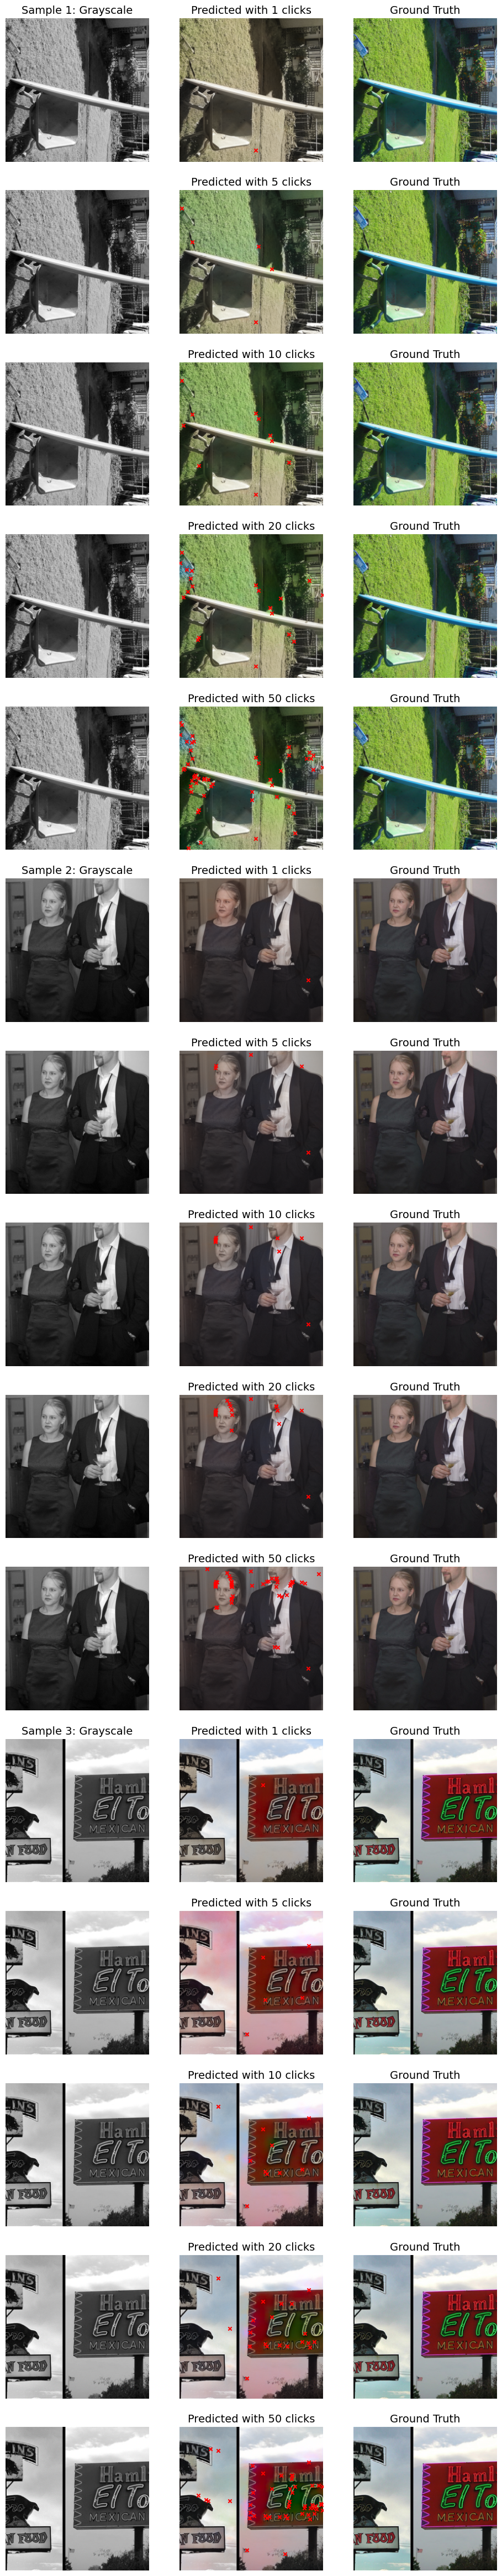

In [7]:
from skimage.metrics import structural_similarity as ssim
import math
import lpips
import warnings

# LPIPS pickle‐load deprecation → suppress
warnings.filterwarnings(
    "ignore",
    message=r".*torch\.load.*weights_only=False.*",
    category=FutureWarning
)

# torchvision pretrained deprecation → suppress
warnings.filterwarnings(
    "ignore",
    message=r".*The parameter 'pretrained' is deprecated.*",
    category=UserWarning
)

checkpoint_path = "checkpoint_final_gumble.pth"
log_file_path = "training_final_gumble.log"

start_phase = 1  # 1: Pretrain ColorNet, 2: Pretrain EditNet, 3: Ping Pong Training
start_pretrain_color_epoch = 0
start_pretrain_edit_epoch = 0
start_pingpong_cycle = 0
scaler = torch.cuda.amp.GradScaler()

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file_path, mode='a'), # Append mode
        logging.StreamHandler() # Also output to console
    ],
    force=True # Override potential existing basicConfig by libraries
)

if os.path.exists(checkpoint_path):
    print("Loading checkpoint from", checkpoint_path)
    logging.info(f"Loading checkpoint from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    colornet_state = ckpt.get("colornet")
    if colornet_state is not None:
        
        print("Checkpoint contains model weights, will resume training.")
    start_phase = ckpt.get("phase", 1)
    start_pretrain_color_epoch = ckpt.get("pretrain_color_epoch", 0)
    start_pretrain_edit_epoch = ckpt.get("pretrain_edit_epoch", 0)
    start_pingpong_cycle = ckpt.get("pingpong_cycle", 0)
    best_psnr = ckpt.get("best_psnr", -float('inf'))
    best_ssim = ckpt.get("best_ssim", -float('inf'))
else:
    best_psnr  = -float('inf')
    best_ssim  = -float('inf')

def main():
    torch.backends.cudnn.benchmark = True  # 启动 cudnn 自动调优
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    BIG_NEG          = -1e4          # for masked softmax
    CLICK_START      = 2             # ColorNet pretrain ramp start
    CLICK_END        = 10            # ColorNet pretrain ramp end
    TAU_START        = 6.0           # EditNet temperature schedule
    TAU_END          = 1.5
    WARMUP_PCT       = 0.02          # 2 % linear warm-up
    
    global start_phase, start_pretrain_color_epoch, start_pretrain_edit_epoch, start_pingpong_cycle, best_psnr, best_ssim
    # , best_lpips
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 4
    image_size = 256
    pretrain_color_epochs = 10
    pretrain_edit_epochs = 6
    colornet_pingpong_cycle = 1
    editnet_pingpong_cycle = 1
    num_pingpong_cycles = 4
    
    train_dataset = CocoColorizationDataset(root_dir="train2017",
                                            transform_size=image_size,
                                            limit=118_000)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size,
                               shuffle=True, num_workers=8, pin_memory=True)
   
    val_dataset   = CocoColorizationDataset(root_dir="val2017",
                                            transform_size=image_size,
                                            limit=5_000)
    val_loader    = DataLoader(val_dataset,   batch_size=batch_size,
                               shuffle=False, num_workers=8, pin_memory=True)
    
    colornet = UNetColorNet(in_channels=4, out_channels=2, conv_block=EnhancedDoubleConv).to(device)
    editnet = EditNet(in_channels=5, out_channels=1, conv_block=EnhancedDoubleConv).to(device)
    freeze_bn(colornet)
    freeze_bn(editnet)
    
    color_optimizer = optim.AdamW(colornet.parameters(), lr=2e-4, weight_decay=1e-4)
    edit_optimizer = optim.AdamW(editnet.parameters(), lr=1e-4, weight_decay=1e-4)
    steps_per_epoch = len(train_loader)
    total_steps_cn  = pretrain_color_epochs * steps_per_epoch
    warmup_steps_cn = int(WARMUP_PCT * total_steps_cn)

    def lr_lambda_cn(step):
        if step < warmup_steps_cn:
            return (step + 1) / warmup_steps_cn
        pct = (step - warmup_steps_cn) / (total_steps_cn - warmup_steps_cn)
        return 0.5 * (1 + math.cos(math.pi * pct))

    color_scheduler = torch.optim.lr_scheduler.LambdaLR(color_optimizer, lr_lambda_cn)

    total_steps_en  = pretrain_edit_epochs * steps_per_epoch
    warmup_steps_en = int(WARMUP_PCT * total_steps_en)

    def lr_lambda_en(step):
        if step < warmup_steps_en:
            return (step + 1) / warmup_steps_en
        pct = (step - warmup_steps_en) / (total_steps_en - warmup_steps_en)
        return 0.5 * (1 + math.cos(math.pi * pct))

    edit_scheduler = torch.optim.lr_scheduler.LambdaLR(edit_optimizer, lr_lambda_en)

    # composite_loss = CompositeLoss(pixel_loss_weight=1.0, lpips_weight=1.0).to(device)
    l1_loss = nn.L1Loss()
    # mse_loss = nn.MSELoss().to(device)
    # criterion_heatmap = nn.MSELoss().to(device)
    gaussian_blur = T.GaussianBlur(kernel_size=11, sigma=3)
    lambda_heatmap = 0.3
    lambda_entropy = 0.05

    lambda_entropy_base = 0.1   # 初始较高熵正则权重
    lambda_entropy_end  = 0.01  # 训练末期较低熵正则权重

    # —— 训练总轮数（Phase-2 + Phase-3） —— #
    num_epochs_edit   = pretrain_edit_epochs         # Phase-2（修正）
    num_epochs_pp     = editnet_pingpong_cycle       # Phase-3
    total_epochs = pretrain_edit_epochs + num_pingpong_cycles * editnet_pingpong_cycle

    # —— λ_entropy 线性 warm-up 到 base 值 —— #
    lambda_ent_max    = 0.5           # 头 20% epoch 用更高权重
    lambda_ent_base   = 0.05          # 之后固定到这个值

    def lambda_entropy_scheduler(epoch: int) -> float:
        warm_epochs = int(total_epochs * 0.2)
        if epoch < warm_epochs:
            return lambda_ent_max - (lambda_ent_max - lambda_ent_base) * epoch / warm_epochs
        else:
            return lambda_ent_base

    # —— τ 余弦衰减（高 → 低） —— #
    tau_init, tau_final = TAU_START, TAU_END

    def temperature_scheduler(epoch: int) -> float:
        """Cosine decay from tau_init → tau_final over total_epochs"""
        import math
        cos = math.cos(math.pi * epoch / total_epochs)
        return tau_final + 0.5 * (tau_init - tau_final) * (1 + cos)


    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        colornet.load_state_dict(ckpt["colornet"])
        editnet.load_state_dict(ckpt["editnet"])
        color_optimizer.load_state_dict(ckpt["color_optimizer"])
        edit_optimizer.load_state_dict(ckpt["edit_optimizer"])
        color_scheduler.load_state_dict(ckpt["color_scheduler"])
        edit_scheduler.load_state_dict(ckpt["edit_scheduler"])
        best_psnr = ckpt["best_psnr"]
        best_ssim = ckpt["best_ssim"]
        freeze_bn(colornet)
        freeze_bn(editnet)
        print(f"Resumed training from Phase {start_phase}, Pretrain_Color_Epoch {start_pretrain_color_epoch}, Pretrain_Edit_Epoch {start_pretrain_edit_epoch}, Pingpong_Cycle {start_pingpong_cycle}")
        logging.info(f"Resumed training from Phase {start_phase}, Pretrain_Color_Epoch {start_pretrain_color_epoch}, Pretrain_Edit_Epoch {start_pretrain_edit_epoch}, Pingpong_Cycle {start_pingpong_cycle}")

    def save_checkpoint(phase, pretrain_color_epoch, pretrain_edit_epoch, pingpong_cycle):
        ckpt = {
            "phase": phase,
            "pretrain_color_epoch": pretrain_color_epoch,
            "pretrain_edit_epoch": pretrain_edit_epoch,
            "pingpong_cycle": pingpong_cycle,
            "colornet": colornet.state_dict(),
            "editnet": editnet.state_dict(),
            "color_optimizer": color_optimizer.state_dict(),
            "edit_optimizer": edit_optimizer.state_dict(),
            "color_scheduler": color_scheduler.state_dict(),
            "edit_scheduler": edit_scheduler.state_dict(),
            "best_psnr": best_psnr,
            "best_ssim":  best_ssim
            # "best_lpips": best_lpips,
        }
        torch.save(ckpt, checkpoint_path)
        print(f"Checkpoint saved at phase {phase}, epoch/cycle {pretrain_color_epoch if phase==1 else pretrain_edit_epoch if phase==2 else pingpong_cycle}")
        logging.info(f"Checkpoint saved at phase {phase}, epoch/cycle {pretrain_color_epoch if phase==1 else pretrain_edit_epoch if phase==2 else pingpong_cycle}")

    # -----------------------------
    # Phase 1: Pretrain ColorNet
    # -----------------------------
    colornet_pretrain_losses = []
    editnet_pretrain_losses = []
    pingpong_color_losses = []
    pingpong_color_psnrs  = []
    pingpong_edit_losses  = []

    os.makedirs("loss_plots", exist_ok=True)
    last_non_zero_lr = 5e-4
    if start_phase <= 1:
        print("=== Phase 1: Pretraining ColorNet ===")
        logging.info("=== Phase 1: Pretraining ColorNet ===")
        for epoch in range(start_pretrain_color_epoch, pretrain_color_epochs):

            print(f"Pretrain ColorNet Epoch {epoch+1}/{pretrain_color_epochs}")
            logging.info(f"Pretrain ColorNet Epoch {epoch+1}/{pretrain_color_epochs}")
            clicks_now = int(CLICK_START + (CLICK_END - CLICK_START) *
                     epoch / (pretrain_color_epochs - 1))
            loss = train_color_net_epoch(colornet, train_loader, color_optimizer, color_scheduler,
                                 device, l1_loss,
                                 total_clicks=clicks_now, clip_grad=1.0)

            print(f"Pretrain ColorNet Epoch {epoch+1}/{pretrain_color_epochs} - Loss: {loss:.4f}, LR: {color_optimizer.param_groups[0]['lr']:.6f}")
            logging.info(f"Pretrain ColorNet Epoch {epoch+1}/{pretrain_color_epochs} - Loss: {loss:.4f}, LR: {color_optimizer.param_groups[0]['lr']:.6f}")
            
            # loss visualization
            colornet_pretrain_losses.append(loss)
            plot_loss_curve(
                loss_list=colornet_pretrain_losses,
                save_path=f"loss_plots/colornet_loss_epoch_{epoch+1}.png",
                show=False,
                title="ColorNet Pretrain Loss"
            )
            
            # checkpoint
            if (epoch+1) % 1 == 0:
                save_checkpoint(phase=1, pretrain_color_epoch=epoch+1, 
                                pretrain_edit_epoch=start_pretrain_edit_epoch, pingpong_cycle=start_pingpong_cycle)
                # 1) 评估
                results = evaluate_color_net(colornet, val_loader, device,
                                 steps=(1,5,10), samples_per_image=3)
                final = results[10]   # 10 次点击后的 {'psnr', 'ssim'}
                # 2) 绘图（假设你有 plot_metric_curve，或直接仿 PSNR 函数新写两个）
                psnr_curve  = {k: results[k]['psnr']  for k in results}
                ssim_curve  = {k: results[k]['ssim']  for k in results}
                plot_curve(psnr_curve,  text="PSNR",  save_path=f"PSNR_plots/…", show=False)
                plot_curve(ssim_curve,  text="SSIM",  save_path=f"SSIM_plots/…", show=False)

                # 3) 日志与模型保存
                print(f"[Val] PSNR@10: {final['psnr']:.2f}, SSIM@10: {final['ssim']:.4f}")
                if final['psnr']  > best_psnr:
                    best_psnr = final['psnr']
                    torch.save(colornet.state_dict(), "best_psnr_model.pth")
                if final['ssim']  > best_ssim:
                    best_ssim = final['ssim']
                    torch.save(colornet.state_dict(), "best_ssim_model.pth")
        
        visualize_pretrain_results(colornet, dataset=val_dataset, device=device,
                               n_samples=3,
                               clicks_list=[1, 5, 10, 20],
                               save_dir="output_images")
        torch.save({'colornet': colornet.state_dict(), 'editnet': editnet.state_dict()}, "pretrained_colornet.pth")

        start_phase = 2  # pretrain ColorNet finish
        save_checkpoint(phase=start_phase, pretrain_color_epoch=pretrain_color_epochs, pretrain_edit_epoch=start_pretrain_edit_epoch, pingpong_cycle=start_pingpong_cycle)

    # -----------------------------
    # Phase 2: Pretrain EditNet
    # -----------------------------
    if start_phase <= 2:
        print("=== Phase 2: Pretraining EditNet ===")
        logging.info("=== Phase 2: Pretraining EditNet ===")

        for epoch in range(start_pretrain_edit_epoch, pretrain_edit_epochs):
            cur_lambda = lambda_entropy_scheduler(epoch)
            cur_tau    = temperature_scheduler(epoch)
            loss = train_edit_net_epoch(
                    colornet, editnet, train_loader, edit_optimizer, device,
                    edit_scheduler,         # ← 6th positional argument
                    l1_loss,         # ← 7th positional argument
                    num_iterations=9,
                    lambda_entropy=cur_lambda,
                    tau=cur_tau,
                    scaler=scaler
                    )
            print(f"Pretrain EditNet Epoch {epoch+1}/{pretrain_edit_epochs} - Loss: {loss:.4f}")
            logging.info(f"Pretrain EditNet Epoch {epoch+1}/{pretrain_edit_epochs} - Loss: {loss:.4f}")

            editnet_pretrain_losses.append(loss)
            plot_loss_curve(
                loss_list=editnet_pretrain_losses,
                save_path="loss_plots/editnet_pretrain_loss.png",
                show=False,
                title="EditNet Pretrain Loss"
            )

            if (epoch+1) % 5 == 0:
                save_checkpoint(phase=2, pretrain_color_epoch=pretrain_color_epochs, pretrain_edit_epoch=epoch+1, pingpong_cycle=start_pingpong_cycle)
        start_phase = 3
        save_checkpoint(phase=start_phase, pretrain_color_epoch=pretrain_color_epochs, pretrain_edit_epoch=pretrain_edit_epochs, pingpong_cycle=start_pingpong_cycle)
    

    # -----------------------------
    # Phase 3: Ping Pong Training
    # -----------------------------
    if start_phase <= 3:
        print("=== Phase 3: Ping Pong Training ===")
        logging.info("=== Phase 3: Ping Pong Training ===")
        T_color_start, T_color_end = 2.0, 0.1
        
        for g in color_optimizer.param_groups:
            g['lr'] = 5e-5
        early_stop_patience  = 2

        for cycle in range(start_pingpong_cycle, num_pingpong_cycles):
            print(f"--- Ping Pong Cycle {cycle+1} ---")
            logging.info(f"--- Ping Pong Cycle {cycle+1} ---")
            global_epoch     = num_epochs_edit + cycle * colornet_pingpong_cycle
            cur_lambda       = lambda_entropy_scheduler(global_epoch)
            cur_tau          = temperature_scheduler(global_epoch)

            # 针对每个 cycle，调整 lambda_entropy: 随 cycle 线性递减
            t_cycle = cycle / max(num_pingpong_cycles - 1, 1)
            lambda_ent = lambda_entropy_base * (1 - t_cycle) + lambda_entropy_end * t_cycle

            logging.info(f"-- Cycle {cycle+1}: lambda_entropy={lambda_ent:.4f} --")

            
            best_cycle_psnr = -float('inf')
            no_improve_cnt = 0

            tau_color = T_color_start - (T_color_start - T_color_end) * (cycle / (num_pingpong_cycles - 1))
            for epoch in range(colornet_pingpong_cycle):
                loss = train_color_net_pingpong_epoch(colornet, editnet, train_loader, color_optimizer, device, 
                                                       l1_loss, num_iterations=9, tau=tau_color, initial_clicks=1, clip_grad=1.0)
                results = evaluate_color_net_pingpong(colornet, editnet, val_loader, device,
                                          steps=(1,5,10), samples_per_image=3)
                final = results[10]
                # 三指标绘图
                psnr_curve  = {k: results[k]['psnr']  for k in results}
                ssim_curve  = {k: results[k]['ssim']  for k in results}

                plot_curve(psnr_curve,  text="PSNR",  save_path=f"PSNR_plots/…", show=False)
                plot_curve(ssim_curve,  text="SSIM",  save_path=f"SSIM_plots/…", show=False)

                print(f"Cycle{cycle+1} Ep{epoch+1}: PSNR@10={final['psnr']:.2f}, SSIM@10={final['ssim']:.4f}")
                logging.info(f"Cycle{cycle+1} Ep{epoch+1} → "
                             f"Loss {loss:.4f} | "
                             f"PSNR@10 {final['psnr']:.2f} | "
                             f"SSIM@10 {final['ssim']:.4f}")
                # 三模型更新
                if final['psnr']  > best_psnr:
                    best_psnr = final['psnr']
                    torch.save(colornet.state_dict(), "best_psnr_model.pth")
                if final['ssim']  > best_ssim:
                    best_ssim = final['ssim']
                    torch.save(colornet.state_dict(), "best_ssim_model.pth")
                    
                if final['psnr'] > best_cycle_psnr + 1e-4:
                    best_cycle_psnr = final['psnr']
                    no_improve_cnt = 0
                else:
                    no_improve_cnt += 1
                    if no_improve_cnt >= early_stop_patience:
                        logging.info(
                            f"Early stopping ColorNet at "
                            f"cycle {cycle+1}, epoch {epoch+1}"
                        )
                        break  # 跳出当前 cycle 中的 ColorNet 训练 loop
                        
            for epoch in range(editnet_pingpong_cycle):
                loss = train_edit_net_pingpong_epoch(
                           colornet, editnet, train_loader, edit_optimizer, device,
                            edit_scheduler,         # ← 6th positional argument
                            l1_loss,         # ← 7th positional argument
                            num_iterations=9,
                            lambda_entropy=cur_lambda,
                            tau=cur_tau,
                            scaler=scaler
                            )
                pingpong_edit_losses.append(loss)

                print(f"Ping Pong EditNet Epoch {epoch+1}/{editnet_pingpong_cycle} - Loss: {loss:.4f}")
                logging.info(f"Ping Pong EditNet Epoch {epoch+1}/{editnet_pingpong_cycle} - Loss: {loss:.4f}")
            save_checkpoint(phase=3, pretrain_color_epoch=pretrain_color_epochs, pretrain_edit_epoch=pretrain_edit_epochs, pingpong_cycle=cycle+1)
        
        # 保存 Ping Pong ColorNet Loss 曲线
        plot_loss_curve(
            loss_list=pingpong_color_losses,
            save_path="loss_plots/pingpong_color_loss.png",
            show=False,
            title="Ping Pong ColorNet Loss"
        )
        # 保存 Ping Pong EditNet Loss 曲线
        plot_loss_curve(
            loss_list=pingpong_edit_losses,
            save_path="loss_plots/pingpong_edit_loss.png",
            show=False,
            title="Ping Pong EditNet Loss"
        )

    print("Training finished!")
    logging.info("Training finished!")

    print("=== Final LPIPS Report on Validation Set ===")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_lpips = lpips.LPIPS(net='alex').to(device)

    psnr_ssim = evaluate_color_net(colornet, val_loader, device, steps=(1,5,10,20), samples_per_image=3)
    lpips_sums = {s:0.0 for s in psnr_ssim}
    counts     = {s:0   for s in psnr_ssim}
    with torch.no_grad():
        for x_L, x_ab in val_loader:
            x_L, x_ab = x_L.to(device), x_ab.to(device)
            pred = colornet(torch.cat([x_L, initial_clickmap(x_L, x_ab, num_clicks=1).to(device)],dim=1))
            for s in psnr_ssim:
                # 这里只示范一次点击后的 LPIPS，若要多点击，可复用 evaluate_color_net_pingpong 逻辑
                pr_rgb = lab_to_rgb_tensor(x_L[0:1,0], pred[0:1]).to(device)
                gt_rgb = lab_to_rgb_tensor(x_L[0:1,0], x_ab[0:1]).to(device)
                pr_n = pr_rgb * 2 - 1; gt_n = gt_rgb * 2 - 1
                lp = loss_lpips(pr_n, gt_n).item()
                lpips_sums[s] += lp
                counts[s]     += 1

    lpips_curve = {s: lpips_sums[s]/counts[s] for s in lpips_sums}
    print("LPIPS @clicks:", lpips_curve)
    logging.info("LPIPS @clicks:", lpips_curve)
    
    visualize_results(colornet, editnet, dataset=val_dataset, device=device, n_samples=3, clicks_list=[1, 5, 10, 20, 50], max_clicks=50, save_dir="output_images")

if __name__ == '__main__':
    main()